This note walks us through the basics of LangGraph while creating a Chatbot as an example.

# 1. Set Up

Run this before running any other part.

## 1.1. Required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_anthropic langchain_openai python-dotenv # part 1
%pip install -U tavily-python langchain_community # part 2

## 1.2. Set API keys

These keys are stored in the `.env` file.

In [2]:
import os

%load_ext dotenv
%dotenv

os.environ.get("OPENAI_API_KEY");
os.environ.get("TAVILY_API_KEY");
os.environ.get("ANTHROPIC_API_KEY");


# Optionally, we can set API keys like this:
# os.environ["OPENAI_API_KEY"] = "your_key"
# os.environ["TAVILY_API_KEY"] = "your_key"
# os.environ["ANTHROPIC_API_KEY"] = "your_key"

# 2. Langgraph Basics

## 2.1. StateGraph and State

`StateGraph` is a class that represents the graph. We initialize this class by passing in a `state` definition. This `state` definition represents a central state object that is updated over time. This `state` is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store).

The attributes of this `state` can be updated in two ways. First, an attribute could be overridden completely. This is useful if we want to nodes to return the new value of an attribute. Second, an attribute could be updated by adding to its value. This is useful if an attribute is a list of actions taken (or something similar) and we want nodes to return new actions taken (and have those automatically added to the attribute).

`Annotated` in python allows developers to declare the type of a reference and provide additional information related to it. Here, 
messages have the type `list`. The `add_messages` function in the annotation defines how this state key should be updated (in this case, it appends messages to the list, rather than overwriting them).

We specify whether an attribute should be **overridden** (default) or **added** to when creating the initial state definition (`add_messages` is for our chatbot; `operator.add` is used in the [LangGraph Docs](https://blog.langchain.dev/langgraph/) by LangChain).

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict 

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## 2.2. Node

After creating a `StateGraph`, we then add nodes with `graph.add_node(name, value)` syntax. The name parameter should be a string that we will use to refer to the node when adding edges. The value parameter should be either a function or LCEL runnable that will be called. This function/LCEL should accept a dictionary in the same form as the State object as **input**, and **output** a dictionary with keys of the State object to update.

Here, we're adding a node called **"chatbot"** that takes the `chatbot` function.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

## 2.3. Edge

After adding nodes, we can then add edges to create the graph. Edges connect nodes together. There are a few types of edges.

### 2.3.1. The Starting and Ending Edge

This is the edge that connects the **start of the graph** to a **particular node**, aka the `entry_point`. This will make it so that that node is the first one called when input is passed to the graph.

In [ ]:
graph_builder.set_entry_point("chatbot")

This is the edge that connects a **paticular node** to the **end of the graph**, aka the `finish_point`.

In [ ]:
graph_builder.set_finish_point("chatbot")

Another way the set the above egdes:

In [ ]:
# from langgraph.graph import START, END
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

### 2.3.2. Normal Edges

These are edges where one node should **ALWAYS** be called after another. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. Since our agent only have 1 node "chatbot", here is an example from the [LangGraph Docs](https://blog.langchain.dev/langgraph/) by LangChain.

In [ ]:
# graph_builder.add_edge("tools", "model")

### 2.3.3. Conditional Edges

These are where a function (often powered by an LLM) is used to determine which node to go to first. To create this edge, we need to pass in three things:

1. **The upstream node:** the output of this node will be looked at to determine what to do next.
2. **A function:** this will be called to determine which node to call next. It should return a string.
3. **A mapping:** this mapping will be used to map the output of the function in (2) to another node. The keys should be possible values that the function in (2) could return. The values should be names of nodes to go to if that value is returned.

An example of this could be that after a model is called we either exit the graph and return to the user, or we call a tool - depending on what a user decides!

In [ ]:
# graph_builder.add_conditional_edge(
#     "model",
#     should_continue,
#     {
#         "end": END,
#         "continue": "tools"
#     }
# )

## 2.4. Compile

After we define our graph, we can compile it into a runnable! This simply takes the graph definition we've created so far an returns a runnable. This runnable exposes all the same method as LangChain runnables (`.invoke`, `.stream`, `.astream_log`, etc) allowing it to be called in the same manner as a chain.

In [ ]:
graph = graph_builder.compile()

## 2.5. Visualize

We can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

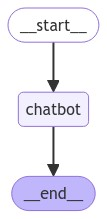

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 2.6. Run 

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# 3. Tavily Search Tool

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

## 3.1. Define the Tool

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
# define tools as a list of tool objects
tools = [tool]

#example
tool.invoke("What's a 'node' in LangGraph?")

## 3.2. Define the Graph

We have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

## 3.3. ToolNode

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 3.4. tools_condition

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [ ]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the `chatbot` node runs, either go to `tools` if it calls a tool, or end the loop if it responds directly".

Like the prebuilt `tools_condition`, our function returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

## 3.5. Visualize

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 3.6. Run


Now we can ask the bot questions outside its training data.

In [ ]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

# 4. Memory 

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is *much* more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

## 4.1. Checkpoiter

To get started, create a `SqliteSaver` checkpointer.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Notice** that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

## 4.2. Graph & ToolNode

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 3.

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 4.3. Compile

Finally, compile the graph with the provided checkpointer.

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

## 4.4. Visualize

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

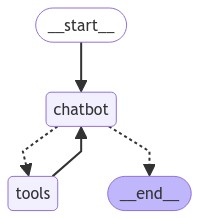

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 4.5. Config

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

## 4.6. Run

Either run Test Run 1 or run Test Run 2, as the user_input will cause a conflict.

### 4.6.1. Test Run 1

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is *not* nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this [LangSmith trace](https://smith.langchain.com/public/48387889-c002-47a8-9f6a-1f6b298db64b/r) to see what's going on.

Don't believe me? Try this using a different config.

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"

events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "2"}},
        stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()

### 4.6.2. Test Run 2

This test run will take in your inputs continuously.

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

remember my name?
================================== Ai Message ==================================

I don't have the ability to remember or store personal information, including names, between interactions. Each conversation is treated independently. If you tell me your name, I can use it during our current chat, but I won't be able to recall it in future conversations.
Goodbye!


## 4.7. snapshot

**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's [LangSmith trace](https://smith.langchain.com/public/4647adf6-3835-4ce3-ba39-26ed4f167411/r) for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [ ]:
snapshot = graph.get_state(config)
snapshot

In [ ]:
snapshot.next  
# (since the graph ended this turn, `next` is empty. 
# If you fetch a state from within a graph invocation, next tells which node will execute next)

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

**Congratulations!** Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

# 5. Human-in-the-loop
Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

## 5.1. Graph

### 5.1.1. State

In [10]:
from typing import Annotated, Sequence, TypedDict
import operator
from langchain_core.messages import BaseMessage

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### 5.1.2. Model

In [11]:
from langchain_openai import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolExecutor

tools = [TavilySearchResults(max_results=2)]
tool_executor = ToolExecutor(tools)

# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)


llm_with_tools = llm.bind_tools(tools)

### 5.1.3. Nodes

In [12]:
# Define the function that determines whether to continue or not
def should_continue(state):
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    # We return a list, because this will get added to the existing list
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [13]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation

# Define the function to execute tools
def call_tool(state):
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = state["messages"][-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

### 5.1.4. Memory

In [14]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

### 5.1.5. Graph

In [16]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

## 5.2. Compile 

Now, compile the graph, specifying to `interrupt_before` the `action` node.

In [17]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

## 5.3. Visualize

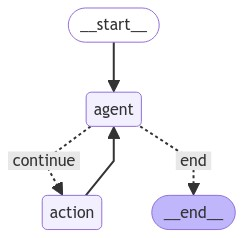

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 5.4. Run

In [19]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
config = {"configurable": {"thread_id": "thread-1"}}
while True:
    for output in app.stream(inputs, config):
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    snapshot = app.get_state(config)
    # If "next" is present, it means we've interrupted mid-execution
    if not snapshot.next:
        break
    inputs = None
    response = input(
        "Do you approve the next step? Type y if you do, anything else to stop: "
    )
    if response != "y":
        break

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DeL4Mg1fPUwr7867eIJsQ4Qe', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_661538dc1f'}, id='run-88baafb4-fb61-408c-b5c0-b0c008cce1b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_DeL4Mg1fPUwr7867eIJsQ4Qe', 'type': 'tool_call'}])]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1721893985, \'localtime\':

This [LangSmith trace](https://smith.langchain.com/public/6a9012c0-bfa2-4fba-8dce-961d233f9512/r) shows the work that was done in the [LangGraph Quickstart Doc](https://langchain-ai.github.io/langgraph/tutorials/introduction/). However, this was the beta version and will output an error if run. The code above is the updated version.

**Congrats!** You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

# 6. Manually Updating the State